Here, we've set up the Colab environment and imported essential libraries. Google Drive is mounted to access the dataset.

In [ ]:
# Required Libraries
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Mount Google Drive and Load the Dataset
drive.mount('/content/gdrive/', force_remount=True)
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/BBBOOOLLLTTT/test.csv')


Mounted at /content/gdrive/


Data is loaded, and an initial cleanup is performed.

<Figure size 1500x1500 with 0 Axes>

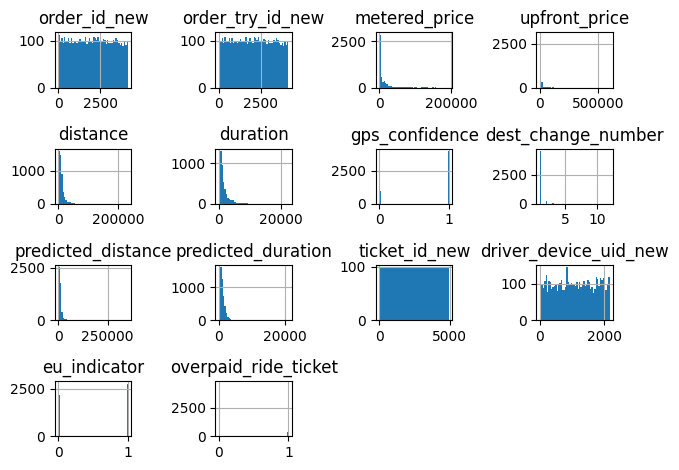

<ipython-input-12-f6dcee88c567>:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_cleaned.corr()


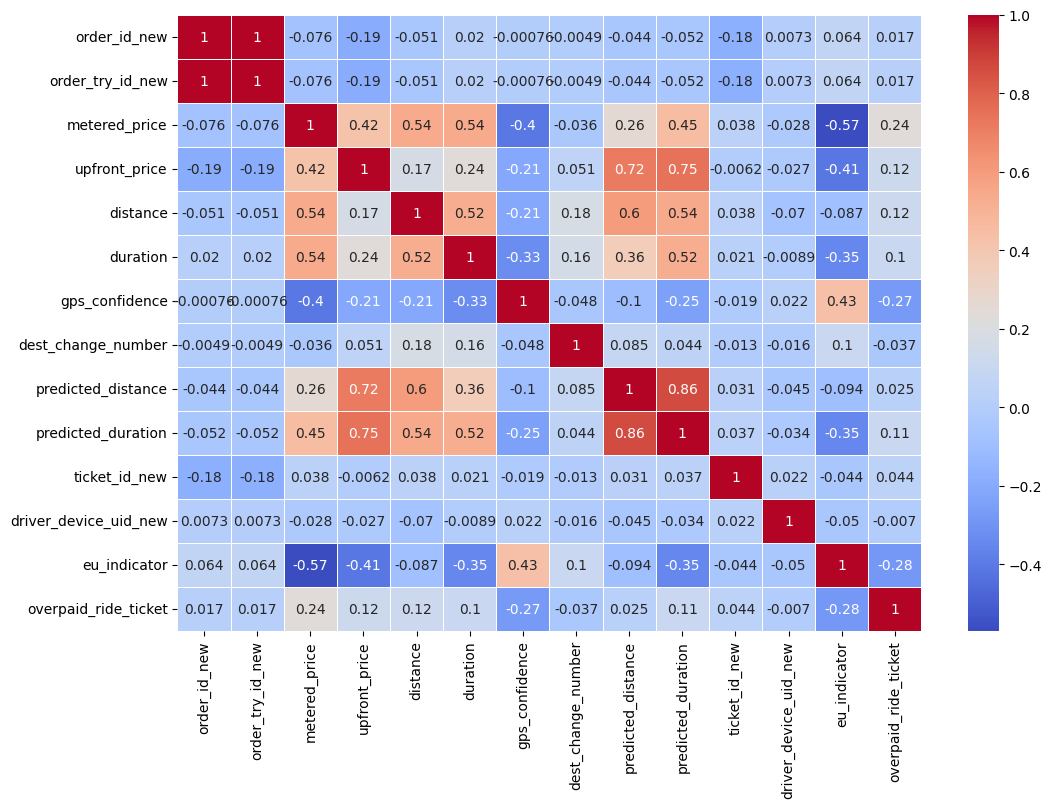

In [ ]:
# Remove columns with >50% missing values
threshold = 0.5 * len(df)
df_cleaned = df.dropna(thresh=threshold, axis=1)

# Remove non-relevant columns
columns_to_drop = ['device_token', 'session_token']
df_cleaned = df_cleaned.drop(columns=columns_to_drop, errors='ignore')

# Histogram Visualization
plt.figure(figsize=(15, 15))
df_cleaned.hist(bins=50)
plt.tight_layout()
plt.show()

# Correlation Heatmap
corr_matrix = df_cleaned.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


In [ ]:
# Remove Outliers
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

df = remove_outliers(df, 'metered_price')
df = remove_outliers(df, 'upfront_price')

# Impute Missing Values
columns_to_impute = {
    'metered_price': 'median',
    'upfront_price': 'median',
    'prediction_price_type': 'mode',
    'predicted_distance': 'median',
    'predicted_duration': 'median',
    'rider_app_version': 'mode'
}
for column, method in columns_to_impute.items():
    if method == 'median':
        df[column].fillna(df[column].median(), inplace=True)
    else:
        df[column].fillna(df[column].mode()[0], inplace=True)


In [ ]:
df['price_per_duration'] = df['metered_price'] / df['duration']

# Calculate Pricing Discrepancies
df['price_difference'] = abs(df['upfront_price'] - df['metered_price'])
df['price_discrepancy_percent'] = (df['price_difference'] / df['metered_price']) * 100

# Analyzing high discrepancies
high_discrepancy_df = df[df['price_discrepancy_percent'] > 20]


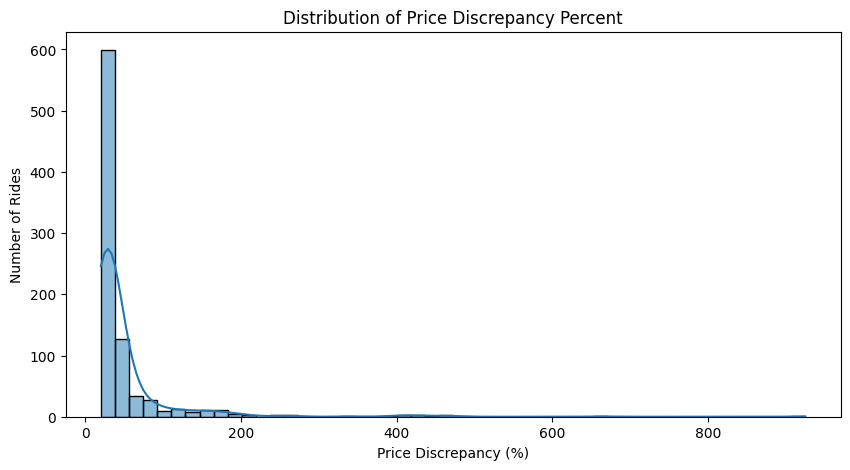

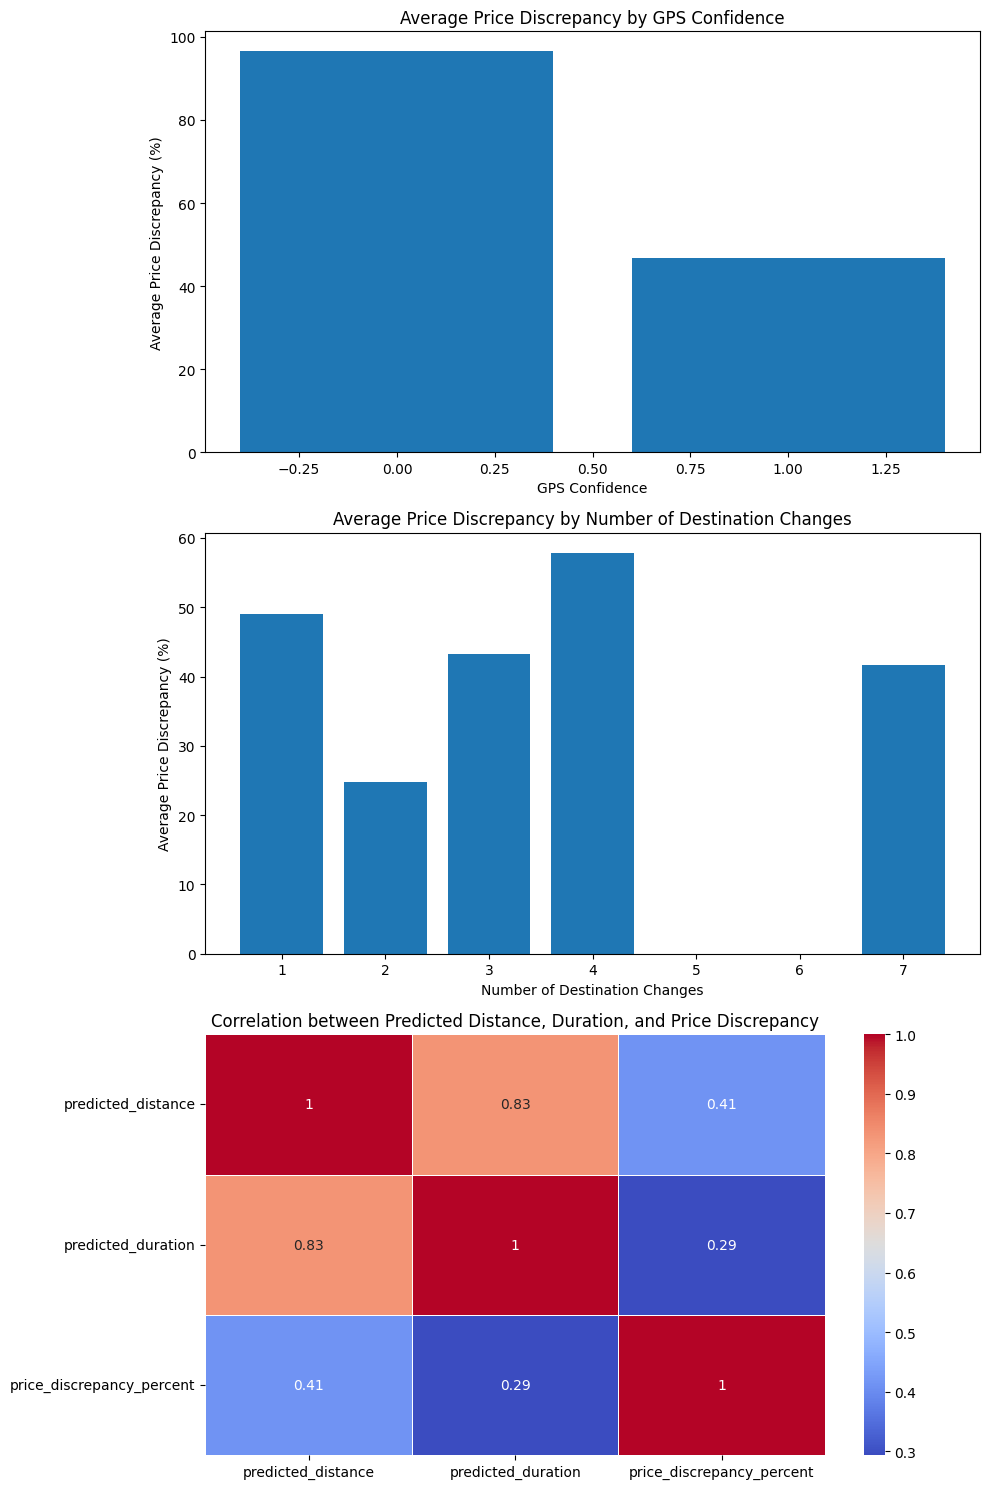

In [ ]:
# Visualize the distribution of price discrepancies
plt.figure(figsize=(10, 5))
sns.histplot(high_discrepancy_df['price_discrepancy_percent'], kde=True, bins=50)
plt.title("Distribution of Price Discrepancy Percent")
plt.xlabel("Price Discrepancy (%)")
plt.ylabel("Number of Rides")
plt.show()

# Analyzing how various factors impact price discrepancy
gps_confidence_discrepancy = high_discrepancy_df.groupby('gps_confidence')['price_discrepancy_percent'].mean()
dest_change_discrepancy = high_discrepancy_df.groupby('dest_change_number')['price_discrepancy_percent'].mean()
predicted_factors_correlation = high_discrepancy_df[['predicted_distance', 'predicted_duration', 'price_discrepancy_percent']].corr()

# Visualizing these impacts
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# GPS Confidence Plot
ax[0].bar(gps_confidence_discrepancy.index, gps_confidence_discrepancy.values)
ax[0].set_title("Average Price Discrepancy by GPS Confidence")
ax[0].set_xlabel("GPS Confidence")
ax[0].set_ylabel("Average Price Discrepancy (%)")

# Destination Change Plot
ax[1].bar(dest_change_discrepancy.index, dest_change_discrepancy.values)
ax[1].set_title("Average Price Discrepancy by Number of Destination Changes")
ax[1].set_xlabel("Number of Destination Changes")
ax[1].set_ylabel("Average Price Discrepancy (%)")

# Predicted Distance vs. Duration Plot
sns.heatmap(predicted_factors_correlation, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax[2])
ax[2].set_title("Correlation between Predicted Distance, Duration, and Price Discrepancy")
plt.tight_layout()
plt.show()


In [ ]:
# Analyzing overpaid rides and fraud scores
overpaid_ride_discrepancy = high_discrepancy_df.groupby('overpaid_ride_ticket')['price_discrepancy_percent'].mean()
fraud_score_correlation = high_discrepancy_df[['fraud_score', 'price_discrepancy_percent']].corr()

print("Overpaid Ride Analysis:")
print(overpaid_ride_discrepancy)

print("\nFraud Score Correlation with Price Discrepancy:")
print(fraud_score_correlation['price_discrepancy_percent'])


Overpaid Ride Analysis:
overpaid_ride_ticket
0    48.707489
1    42.772459
Name: price_discrepancy_percent, dtype: float64

Fraud Score Correlation with Price Discrepancy:
fraud_score                 -0.018331
price_discrepancy_percent    1.000000
Name: price_discrepancy_percent, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Selecting features and target
features = ['predicted_distance', 'predicted_duration', 'gps_confidence']
target = 'upfront_price'

X = df[features]
y = df[target]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 0.9306686507936509


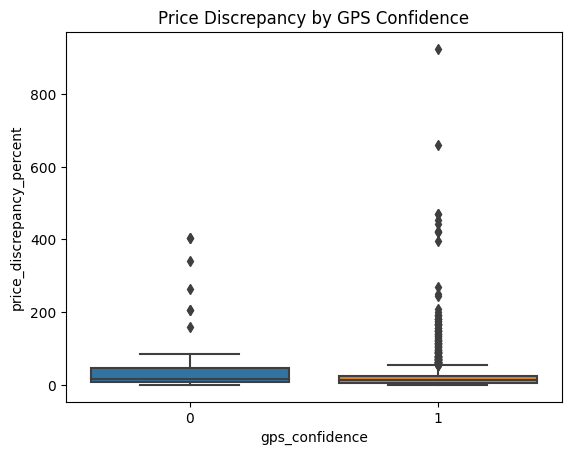

In [ ]:
sns.boxplot(x='gps_confidence', y='price_discrepancy_percent', data=df)
plt.title("Price Discrepancy by GPS Confidence")
plt.show()


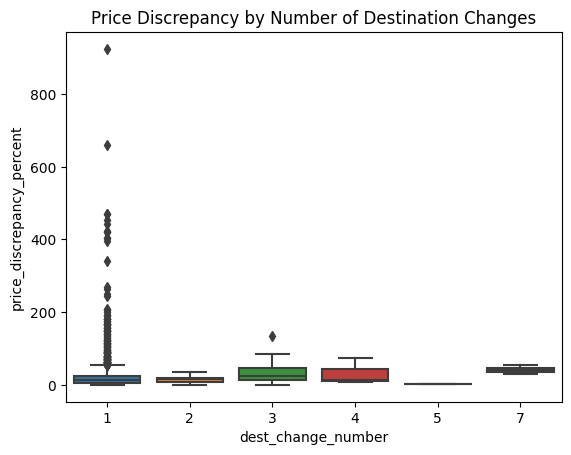

In [ ]:
sns.boxplot(x='dest_change_number', y='price_discrepancy_percent', data=df)
plt.title("Price Discrepancy by Number of Destination Changes")
plt.show()


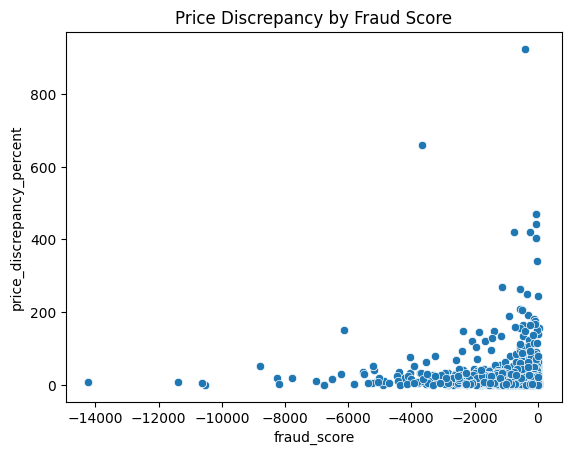

In [ ]:
sns.scatterplot(x='fraud_score', y='price_discrepancy_percent', data=df)
plt.title("Price Discrepancy by Fraud Score")
plt.show()


In [ ]:
# Grouping by ticket_id_new and calculating mean price_discrepancy_percent
ticket_analysis = df.groupby('ticket_id_new')['price_discrepancy_percent'].mean()
print(ticket_analysis)


ticket_id_new
0         1.834862
8         6.204906
9         0.572363
11       30.973451
12        1.983003
           ...    
4933      2.154274
4934    152.000000
4935     31.350114
4937     18.542337
4938     18.542337
Name: price_discrepancy_percent, Length: 2519, dtype: float64


In [ ]:
# Grouping by rider_app_version and calculating mean price_discrepancy_percent
app_version_analysis = df.groupby('rider_app_version')['price_discrepancy_percent'].mean()
print(app_version_analysis)


rider_app_version
CA.4.41    28.000000
CA.4.45    18.367347
CA.4.47    17.431193
CA.4.71     0.000000
CA.4.73    79.771784
             ...    
CI.4.19    20.848231
CI.4.20    12.986247
CI.4.21    13.699295
CI.4.22    14.202148
CI.4.23    13.043419
Name: price_discrepancy_percent, Length: 83, dtype: float64


Best parameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

RMSE: 1.4310018306176868
R-squared: 0.8060065042625169

Feature Importances:
              Feature  Importance
3    interaction_term    0.764233
0  predicted_distance    0.208219
1  predicted_duration    0.025996
2      gps_confidence    0.001552


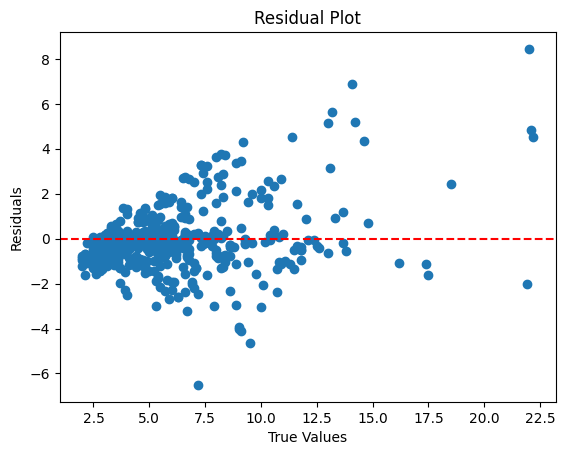


Cross-validated MAE: 0.9380346622985636


In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering: Creating an interaction term
df['interaction_term'] = df['predicted_distance'] * df['predicted_duration']

# Updating features and target with the new interaction term
features = ['predicted_distance', 'predicted_duration', 'gps_confidence', 'interaction_term']
target = 'upfront_price'

X = df[features]
y = df[target]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Tuning: GridSearchCV to find the best hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Printing the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Model Evaluation: Calculating RMSE and R-squared
y_pred = grid_search.best_estimator_.predict(X_test)
print(f'\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R-squared: {r2_score(y_test, y_pred)}')

# Feature Selection: Evaluating feature importances
feature_importances = grid_search.best_estimator_.feature_importances_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(features_df)

# Error Analysis: Residual Plot
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Cross-validation: Calculating cross-validated MAE
scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f'\nCross-validated MAE: {-np.mean(scores)}')


In [ ]:
# Importing necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Checking the distribution of the target variable
print('Statistics for Upfront Price:')
print(df['upfront_price'].describe())

# Checking for categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns

# Printing unique values of categorical variables if any
print('\nCategorical Columns:')
for col in categorical_cols:
    print(f'{col}: {df[col].nunique()} unique values')

# If there are categorical variables, encode them using LabelEncoder
if len(categorical_cols) > 0:
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    print("\nCategorical variables have been encoded.")

# Checking for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("\nMissing Values:")
print(missing_values)


Statistics for Upfront Price:
count    2519.000000
mean        6.275149
std         3.857697
min         2.000000
25%         3.700000
50%         5.200000
75%         7.550000
max        32.000000
Name: upfront_price, dtype: float64

Categorical Columns:
calc_created: 2265 unique values
entered_by: 2 unique values
b_state: 1 unique values
prediction_price_type: 1 unique values
change_reason_pricing: 0 unique values
rider_app_version: 83 unique values
order_state: 1 unique values
order_try_state: 1 unique values
driver_app_version: 29 unique values
device_name: 258 unique values

Categorical variables have been encoded.

Missing Values:
device_token    2519
fraud_score      577
dtype: int64


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer

# Handling Missing Values
imputer = SimpleImputer(strategy='mean')
df['fraud_score'] = imputer.fit_transform(df[['fraud_score']])

# Feature Selection
features = ['predicted_distance', 'predicted_duration', 'gps_confidence', 'interaction_term', 'fraud_score']
target = 'upfront_price'

X = df[features]
y = df[target]

# Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
print(f'MAE for Gradient Boosting Regressor: {mean_absolute_error(y_test, gbr_pred)}')

# Voting Regressor
voting_reg = VotingRegressor(estimators=[('rf', RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200, random_state=42)),
                                        ('gbr', GradientBoostingRegressor(random_state=42))])
voting_reg.fit(X_train, y_train)
voting_pred = voting_reg.predict(X_test)
print(f'MAE for Voting Regressor: {mean_absolute_error(y_test, voting_pred)}')


MAE for Gradient Boosting Regressor: 0.882201513572699
MAE for Voting Regressor: 0.8858123860649229


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train and evaluate the model with the best parameters
best_gbr = GradientBoostingRegressor(**best_params, random_state=42)
best_gbr.fit(X_train, y_train)
best_gbr_pred = best_gbr.predict(X_test)
print(f'MAE for Best Gradient Boosting Regressor: {mean_absolute_error(y_test, best_gbr_pred)}')


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
MAE for Best Gradient Boosting Regressor: 0.8839004014932101


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(X_train)

# Train Gradient Boosting Regressor on polynomial features
gbr_poly = GradientBoostingRegressor(random_state=42)
gbr_poly.fit(X_poly, y_train)

# Evaluate the model
X_test_poly = poly.transform(X_test)
gbr_poly_pred = gbr_poly.predict(X_test_poly)
print(f'MAE for Gradient Boosting Regressor with Polynomial Features: {mean_absolute_error(y_test, gbr_poly_pred)}')


MAE for Gradient Boosting Regressor with Polynomial Features: 0.8847425486859798


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define the base models and the meta-model
base_models = [
    ('rf', RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200, random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]
meta_model = LinearRegression()

# Create the stacking regressor
stacking_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_reg.fit(X_train, y_train)

# Evaluate the model
stacking_pred = stacking_reg.predict(X_test)
print(f'MAE for Stacking Regressor: {mean_absolute_error(y_test, stacking_pred)}')


MAE for Stacking Regressor: 0.8843188743124462


In [ ]:
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-train the Gradient Boosting Regressor with scaled features
gbr_scaled = GradientBoostingRegressor(random_state=42)
gbr_scaled.fit(X_train_scaled, y_train)

# Evaluate the model
gbr_scaled_pred = gbr_scaled.predict(X_test_scaled)
scaled_mae = mean_absolute_error(y_test, gbr_scaled_pred)
print(f'MAE for Gradient Boosting Regressor with Scaled Features: {scaled_mae}')


MAE for Gradient Boosting Regressor with Scaled Features: 0.8818228173579227


In [ ]:
# Experiment with a simpler model
simple_gbr = GradientBoostingRegressor(max_depth=2, n_estimators=50, random_state=42)
simple_gbr.fit(X_train, y_train)
simple_gbr_pred = simple_gbr.predict(X_test)
simple_mae = mean_absolute_error(y_test, simple_gbr_pred)
print(f'MAE for Simpler Gradient Boosting Regressor: {simple_mae}')


MAE for Simpler Gradient Boosting Regressor: 0.8873043016241808


In [ ]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

# Check for constant features
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print(f'Constant features: {constant_features}')


Number of duplicate rows: 0
Constant features: ['b_state', 'prediction_price_type', 'change_reason_pricing', 'order_state', 'order_try_state', 'eu_indicator']


In [ ]:
# List of constant features
constant_features = ['b_state', 'prediction_price_type', 'change_reason_pricing', 'order_state', 'order_try_state', 'eu_indicator']

# Dropping constant features
df = df.drop(columns=constant_features)

# Update feature list
features = [feature for feature in features if feature not in constant_features]

# Splitting the data again
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import xgboost as xgb

# Training XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10, random_state=42)
xg_reg.fit(X_train, y_train)

# Evaluating the model
xg_reg_pred = xg_reg.predict(X_test)
xg_mae = mean_absolute_error(y_test, xg_reg_pred)
print(f'MAE for XGBoost Regressor: {xg_mae}')


MAE for XGBoost Regressor: 1.486165750026703


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter tuning for XGBoost
param_distributions = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
    'alpha': [1, 5, 10, 20]
}

random_search = RandomizedSearchCV(xg_reg, param_distributions, n_iter=50, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_xg = random_search.best_params_
print(f'Best parameters for XGBoost: {best_params_xg}')

# Train and evaluate the model with the best parameters
best_xg_reg = xgb.XGBRegressor(**best_params_xg, random_state=42)
best_xg_reg.fit(X_train, y_train)
best_xg_reg_pred = best_xg_reg.predict(X_test)
best_xg_mae = mean_absolute_error(y_test, best_xg_reg_pred)
print(f'MAE for Best XGBoost Regressor: {best_xg_mae}')


Best parameters for XGBoost: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0, 'alpha': 20}
MAE for Best XGBoost Regressor: 0.9147482432070232


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.2 MB/s eta 0:00:00


MAE: 0.44664747618118944
                      Feature        Score
8          predicted_distance  9380.984881
9          predicted_duration  5642.890571
20           interaction_term  5569.439685
3                    distance  3156.075104
4                    duration  1001.836005
18           price_difference   139.816415
7          dest_change_number    47.435002
6                  entered_by    44.869556
19  price_discrepancy_percent    38.468429
5              gps_confidence    12.738955
0                order_id_new     9.135358
1            order_try_id_new     9.134962
2                calc_created     8.394975
11          rider_app_version     5.942213
13      driver_device_uid_new     4.582120
16                fraud_score     3.233028
10              ticket_id_new     2.952512
14                device_name     0.501203
17         price_per_duration     0.220099
15       overpaid_ride_ticket     0.161003
12         driver_app_version     0.058935


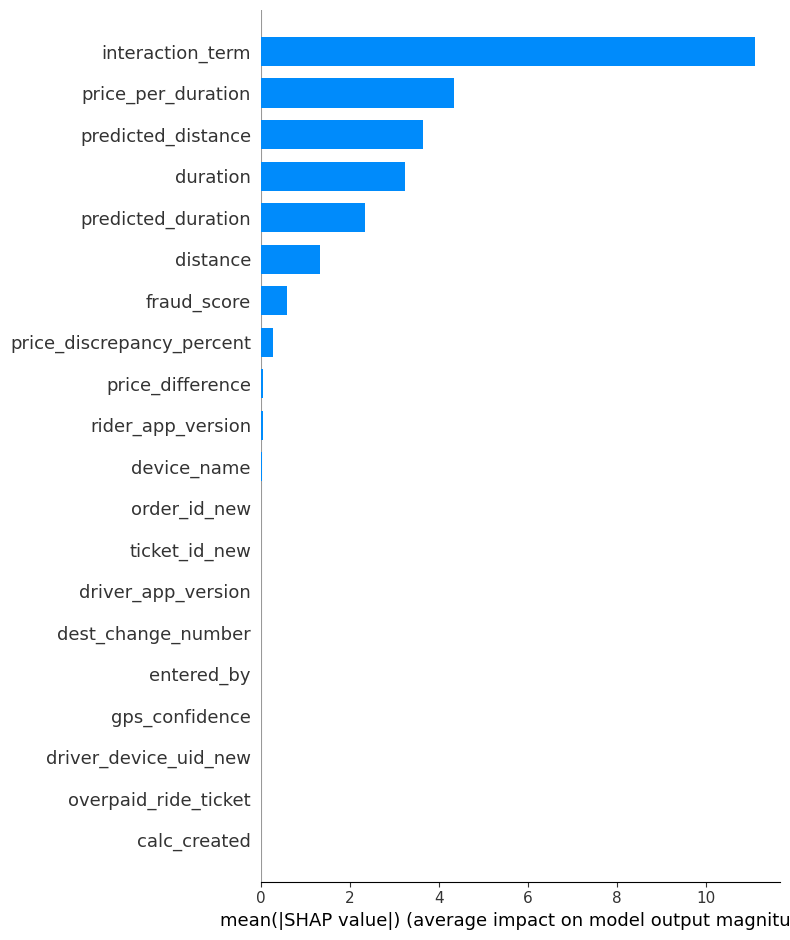

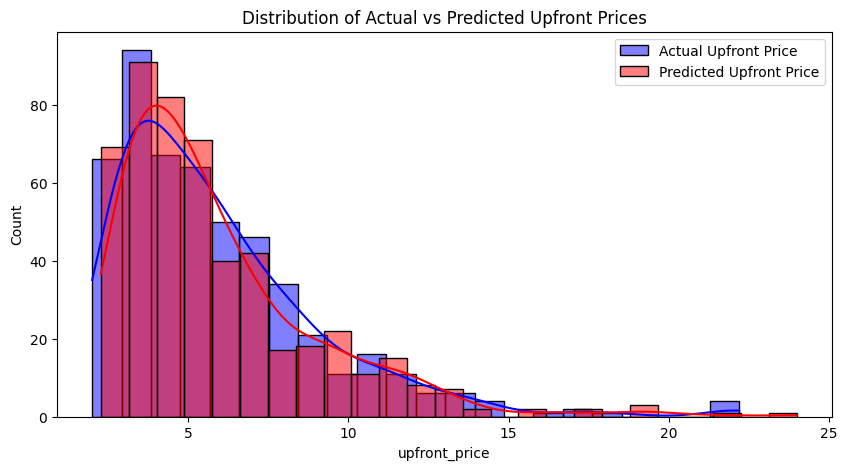

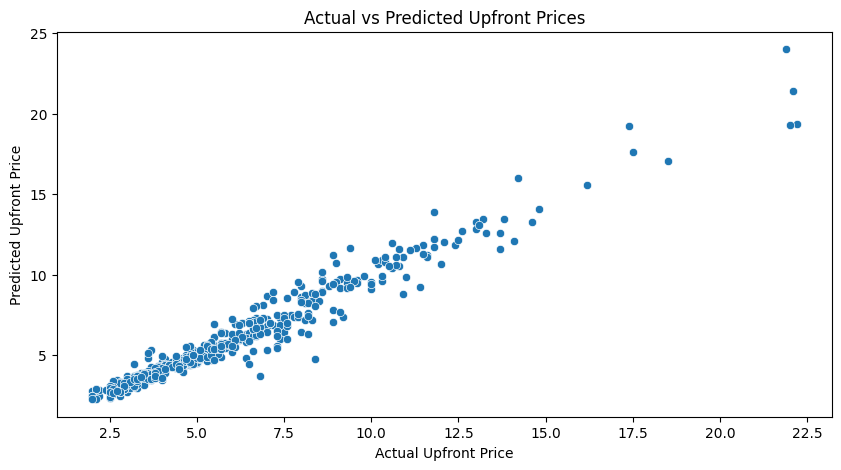

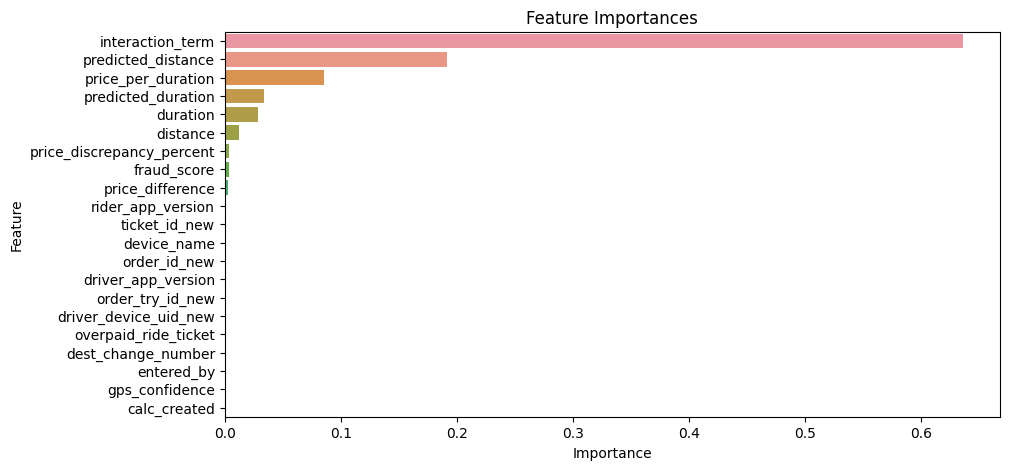

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import shap

# Assuming df is your DataFrame
features = [col for col in df.columns if col not in ['upfront_price', 'metered_price']]  # Update as necessary
X = df[features]
y = df['upfront_price']  # Assuming upfront_price is the target variable

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Replace infinite values with NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Identify columns where all values are NaN
nan_cols = X_train.columns[X_train.isna().all()].tolist()

# Drop these columns from X_train and X_test
X_train = X_train.drop(columns=nan_cols)
X_test = X_test.drop(columns=nan_cols)

# Fill remaining NaN values with the mean of respective columns
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # Use train mean to avoid data leakage

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_scaled, y_train)

# Evaluating the model
predictions = gbr.predict(X_test_scaled)
mae = mean_absolute_error(y_test, predictions)
print(f'MAE: {mae}')

# Feature Selection
selector = SelectKBest(f_regression, k='all')
selector.fit(X_train, y_train)
feature_scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
sorted_features = feature_scores.sort_values(by='Score', ascending=False)
print(sorted_features)

# Model Interpretation
explainer = shap.Explainer(gbr)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Advanced Visualization
# Visualize the distribution of actual vs predicted upfront prices
plt.figure(figsize=(10, 5))
sns.histplot(y_test, color='blue', label='Actual Upfront Price', kde=True)
sns.histplot(predictions, color='red', label='Predicted Upfront Price', kde=True)
plt.legend()
plt.title('Distribution of Actual vs Predicted Upfront Prices')
plt.show()

# Visualize the relationship between actual and predicted prices
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=predictions)
plt.title('Actual vs Predicted Upfront Prices')
plt.xlabel('Actual Upfront Price')
plt.ylabel('Predicted Upfront Price')
plt.show()

# Visualize the feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': gbr.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.show()


In [ ]:
df

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,dest_change_number,...,rider_app_version,driver_app_version,driver_device_uid_new,device_name,overpaid_ride_ticket,fraud_score,price_per_duration,price_difference,price_discrepancy_percent,interaction_term
0,22,22,43,4.04,10.0,2839,700,1,0,1,...,76,12,1596,221,0,-1383.000000,0.005771,5.96,147.524752,14601944.0
1,618,618,348,6.09,3.6,5698,493,1,0,1,...,38,14,1578,154,0,-684.980433,0.012353,2.49,40.886700,822960.0
2,657,657,304,4.32,3.5,4426,695,1,0,1,...,38,12,951,124,0,-166.000000,0.006216,0.82,18.981481,1775733.0
5,1209,1209,661,6.11,6.3,4924,513,1,0,1,...,19,14,1591,82,0,-684.980433,0.011910,0.19,3.109656,2743684.0
7,1662,1662,863,2.61,6.5,2020,412,1,0,1,...,77,12,1701,170,0,-2350.000000,0.006335,3.89,149.042146,7587960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,3292,3292,1749,3.31,3.2,3343,471,1,0,1,...,78,16,1203,162,0,-1000.000000,0.007028,0.11,3.323263,1441338.0
4937,3236,3236,1772,7.01,5.6,10919,1465,1,0,1,...,65,16,1779,60,0,-4.000000,0.004785,1.41,20.114123,9283638.0
4938,3513,3513,1862,10.89,13.7,15672,1449,1,0,1,...,40,12,1612,58,0,-286.000000,0.007516,2.81,25.803489,27346852.0
4940,4051,4051,2179,7.50,7.4,5303,486,1,0,1,...,40,16,2061,32,0,-192.000000,0.015432,0.10,1.333333,2560218.0
